# Time Series prediction with PyTorch using an LSTM

Frederico Furst Bittencourt

2024/May/05

Inspired by https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

In [2]:
os.chdir("D:\\Google Drive\\Mobmed\\")

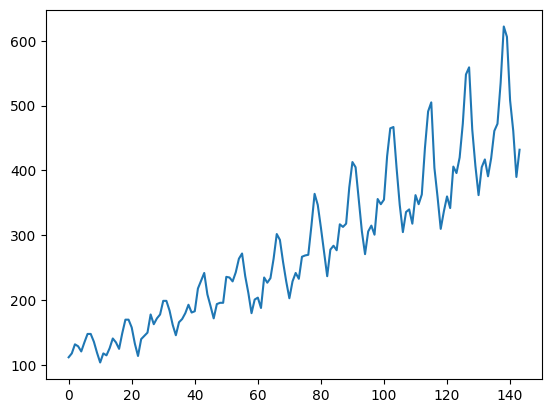

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [2]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [3]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [4]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


C:\Users\lenovo\AppData\Local\Temp\ipykernel_1744\707328685.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [5]:
...
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=150, num_layers=4, batch_first=True)
        self.linear = nn.Linear(150, 1)
    def forward(self, x):
        # x, _ = self.lstm(x)
        # x = self.linear(x)
        x, _ = self.lstm(x)
        # extract only the last time step
        # x = x[:, -1, :]
        x = self.linear(x)
        return x


In [6]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.9119, test RMSE 422.3153
Epoch 100: train RMSE 114.2931, test RMSE 300.3196
Epoch 200: train RMSE 75.0099, test RMSE 237.4325
Epoch 300: train RMSE 71.1887, test RMSE 217.3219
Epoch 400: train RMSE 71.1493, test RMSE 215.2637
Epoch 500: train RMSE 71.1494, test RMSE 214.9231
Epoch 600: train RMSE 71.1491, test RMSE 215.1153
Epoch 700: train RMSE 71.1492, test RMSE 215.2274
Epoch 800: train RMSE 71.1492, test RMSE 215.2242
Epoch 900: train RMSE 71.1491, test RMSE 215.1584
Epoch 1000: train RMSE 71.1491, test RMSE 215.0603
Epoch 1100: train RMSE 71.1491, test RMSE 215.1518
Epoch 1200: train RMSE 71.1491, test RMSE 215.0818
Epoch 1300: train RMSE 71.1491, test RMSE 215.0480
Epoch 1400: train RMSE 71.1491, test RMSE 215.1246
Epoch 1500: train RMSE 71.1492, test RMSE 214.9861
Epoch 1600: train RMSE 41.1233, test RMSE 171.1341
Epoch 1700: train RMSE 29.8597, test RMSE 134.5530
Epoch 1800: train RMSE 24.7021, test RMSE 116.4499
Epoch 1900: train RMSE 24.0442, test RMSE

In [7]:
y_pred.shape

torch.Size([7, 1, 1])

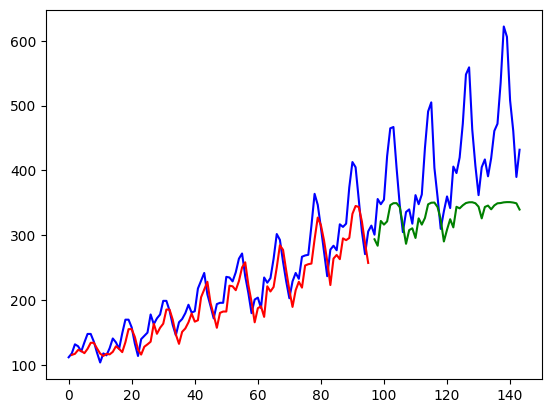

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train) [:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test) [:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

Full code below

Epoch 0: train RMSE 225.7912, test RMSE 425.0297
Epoch 100: train RMSE 176.6434, test RMSE 373.4466
Epoch 200: train RMSE 139.9817, test RMSE 333.2643
Epoch 300: train RMSE 110.3354, test RMSE 297.8902
Epoch 400: train RMSE 88.4066, test RMSE 267.2029
Epoch 500: train RMSE 68.1495, test RMSE 236.5097
Epoch 600: train RMSE 53.5212, test RMSE 208.3018
Epoch 700: train RMSE 43.0030, test RMSE 184.4762
Epoch 800: train RMSE 35.7871, test RMSE 163.5548
Epoch 900: train RMSE 31.0109, test RMSE 145.7979
Epoch 1000: train RMSE 27.6910, test RMSE 130.8190
Epoch 1100: train RMSE 25.1723, test RMSE 118.3399
Epoch 1200: train RMSE 23.5531, test RMSE 108.2986
Epoch 1300: train RMSE 22.8833, test RMSE 99.9648
Epoch 1400: train RMSE 21.9468, test RMSE 93.4607
Epoch 1500: train RMSE 21.1429, test RMSE 89.0946
Epoch 1600: train RMSE 21.1806, test RMSE 84.1626
Epoch 1700: train RMSE 20.2052, test RMSE 82.1994
Epoch 1800: train RMSE 19.6748, test RMSE 80.4972
Epoch 1900: train RMSE 19.6569, test RMSE 77.

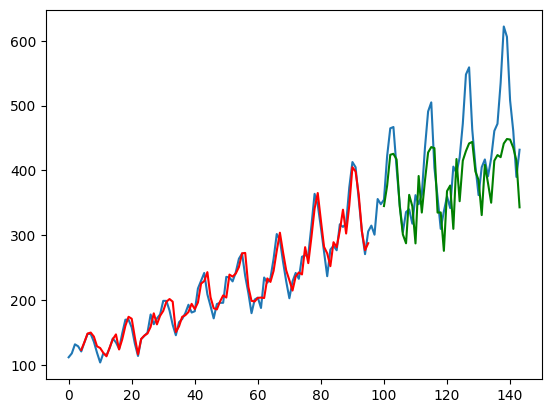

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()